In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
source_dir=os.path.join('/kaggle/input/img-align-celeba/')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

In [3]:
warnings.filterwarnings('ignore')

In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata(source_dir)

In [5]:
print('metadata shape :', metadata.shape)

metadata shape : (202599,)


In [6]:
metadata[1500]

/kaggle/input/img-align-celeba/img_align_celeba/133339.jpg

In [7]:
type(metadata[1500]), metadata[1500].image_path()

(__main__.IdentityMetadata,
 '/kaggle/input/img-align-celeba/img_align_celeba/133339.jpg')

In [8]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

2024-03-04 08:37:50.281380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 08:37:50.281486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 08:37:50.505801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
model = vgg_face()

model.load_weights('../input/vgg-face-weights/vgg_face_weights.h5')

In [11]:
model.layers[0], model.layers[-2]

(<ZeroPadding2D name=zero_padding2d, built=True>,
 <Flatten name=flatten, built=True>)

In [12]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [13]:
type(vgg_face_descriptor)

keras.src.models.functional.Functional

In [14]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>],
 [<KerasTensor shape=(None, 2622), dtype=float32, sparse=False, name=keras_tensor_703>])

In [15]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
(2622,)


I0000 00:00:1709541499.804724      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 202599


In [17]:
embeddings = np.load('/kaggle/input/embeddings/embeddings.npy')

In [18]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (202599, 2622)


In [19]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [20]:
source_dir2 = os.path.join('/kaggle/input/img-input')
img_input1 = load_metadata(source_dir2)

In [21]:
embeddings_input = np.zeros((img_input1.shape[0], 2622))
for i, m in enumerate(img_input1):
    img_path2 = img_input1[i].image_path()
    img2 = load_image(img_path2)
    img2 = (img2 / 255.).astype(np.float32)
    img2 = cv2.resize(img2, dsize = (224,224))
    embedding_vector2 = vgg_face_descriptor.predict(np.expand_dims(img2, axis=0))[0]
    embeddings_input[i] = embedding_vector2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [22]:
embeddings_input

array([[ 0.00629004,  0.00990794,  0.00998059, ..., -0.02813442,
        -0.01123934, -0.00151094],
       [-0.00281887, -0.0061203 , -0.018304  , ..., -0.03073436,
        -0.00060538,  0.02204285],
       [ 0.01530847, -0.00680375,  0.01036573, ..., -0.01001994,
        -0.01141698, -0.00696505],
       [ 0.0027415 ,  0.00691468, -0.00748272, ..., -0.02529602,
         0.00852406,  0.02674595],
       [ 0.00511042,  0.0003264 ,  0.00702502, ..., -0.00458573,
         0.01671549,  0.02109444]])

In [23]:
np.save('embeddings_input.npy', embeddings_input)

In [24]:
input_embedding = embeddings_input[4] / np.linalg.norm(embeddings_input[4])
distances = np.array([distance(embeddings_input[4], emb) for emb in embeddings])

# Find indices of the most similar images
num_similar_images = 10  # You can change this according to your requirement
most_similar_indices = np.argsort(distances)[:num_similar_images]

# Retrieve the most similar images from embeddings
most_similar_images = embeddings[most_similar_indices]


In [25]:
most_similar_indices

array([ 45310,  97405, 198612,  45324, 188086, 141258, 123993,  66622,
       174677, 114219])

In [26]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings_input[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(img_input1[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path())); 

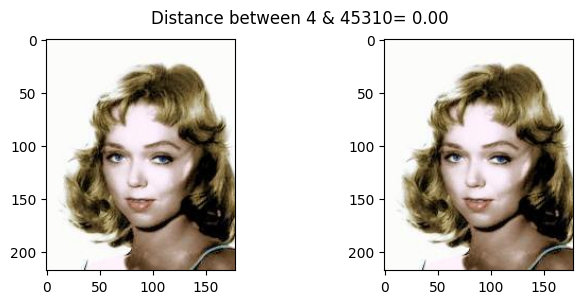

In [27]:
show_pair(4,45310)